In [17]:
import pandas as pd
import spacy
from spacy.matcher import Matcher
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

Task 1 : Basic Data Exploration using Pandas

Import Dataset

In [2]:
df = pd.read_csv("Real Estate Data V21.csv")

Basic Data Exploration

In [3]:
print("Shape of dataset:", df.shape)           

Shape of dataset: (14528, 9)


In [4]:
print("Columns:", df.columns.tolist())

Columns: ['Name', 'Property Title', 'Price', 'Location', 'Total_Area', 'Price_per_SQFT', 'Description', 'Baths', 'Balcony']


In [5]:
print("Data types:\n", df.dtypes)            

Data types:
 Name               object
Property Title     object
Price              object
Location           object
Total_Area          int64
Price_per_SQFT    float64
Description        object
Baths               int64
Balcony            object
dtype: object


In [6]:
df.head()

,Name,Property Title,Price,Location,Total_Area,Price_per_SQFT,Description,Baths,Balcony
0,Casagrand ECR 14,"4 BHK Flat for sale in Kanathur Reddikuppam, C...",₹1.99 Cr,"Kanathur Reddikuppam, Chennai",2583,7700.0,Best 4 BHK Apartment for modern-day lifestyle ...,4,Yes
1,"Ramanathan Nagar, Pozhichalur,Chennai",10 BHK Independent House for sale in Pozhichal...,₹2.25 Cr,"Ramanathan Nagar, Pozhichalur,Chennai",7000,3210.0,Looking for a 10 BHK Independent House for sal...,6,Yes
2,DAC Prapthi,"3 BHK Flat for sale in West Tambaram, Chennai",₹1.0 Cr,"Kasthuribai Nagar, West Tambaram,Chennai",1320,7580.0,"Property for sale in Tambaram, Chennai. This 3...",3,No
3,"Naveenilaya,Chepauk, Triplicane,Chennai",7 BHK Independent House for sale in Triplicane...,₹3.33 Cr,"Naveenilaya,Chepauk, Triplicane,Chennai",4250,7840.0,Entire Building for sale with 7 units of singl...,5,Yes
4,VGN Spring Field Phase 1,"2 BHK Flat for sale in Avadi, Chennai",₹48.0 L,"Avadi, Chennai",960,5000.0,"Property for sale in Avadi, Chennai. This 2 BH...",3,Yes


In [7]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 Name              0
Property Title    0
Price             0
Location          0
Total_Area        0
Price_per_SQFT    0
Description       0
Baths             0
Balcony           0
dtype: int64


In [8]:
print("Duplicate values:\n",df.duplicated().sum())  #gives exact  duplicate rows

Duplicate values:
 8


In [9]:
print("Unique values:\n",df.nunique())

Unique values:
 Name               9998
Property Title     6507
Price               891
Location           7050
Total_Area         1774
Price_per_SQFT     2094
Description       14490
Baths                 6
Balcony               2
dtype: int64


In [10]:
df.describe()

,Total_Area,Price_per_SQFT,Baths
count,14528.000000,14528.000000,14528.000000
mean,1297.916988,11719.456222,2.751239
std,1245.694305,49036.068632,0.898243
min,70.000000,0.000000,1.000000
25%,650.000000,4480.000000,2.000000
50%,1000.000000,6050.000000,3.000000
75%,1439.000000,9312.500000,3.000000
max,35000.000000,999000.000000,6.000000


Task 2 : Extraction Of Number of bedrooms from property Title column by Using NLP

In [11]:
nlp = spacy.load("en_core_web_sm")
matcher = Matcher(nlp.vocab)

In [12]:
# digit + bhk/bedrooms
pattern1 = [{"LIKE_NUM": True}, {"LOWER": {"IN": ["bhk", "bedroom", "bedrooms"]}}]

# word-number + bhk/bedrooms
pattern2 = [{"LOWER": {"IN": ["one","two","three","four","five","six","seven","eight","nine","ten"]}},
            {"LOWER": {"IN": ["bhk","bedroom","bedrooms"]}}]

matcher.add("BEDROOMS", [pattern1, pattern2])

In [13]:
word_to_num = {
    "one": 1, "two": 2, "three": 3, "four": 4, "five": 5,
    "six": 6, "seven": 7, "eight": 8, "nine": 9, "ten": 10
}

def extract_bedrooms(text):
    doc = nlp(str(text).lower())
    matches = matcher(doc)

    for match_id, start, end in matches:
        span = doc[start:end]
        first_token = span[0]

        # Case 1: numeric value like "2 bhk"
        if first_token.like_num:
            try:
                return int(float(first_token.text))  # Handles "2.0", etc.
            except ValueError:
                return None

        # Case 2: written numbers like "two bedrooms"
        if first_token.text in word_to_num:
            return word_to_num[first_token.text]

    return None

In [14]:
df["Bedrooms"] = df["Property Title"].apply(extract_bedrooms)
print(df[["Property Title", "Bedrooms"]].head(20))

                                       Property Title  Bedrooms
0   4 BHK Flat for sale in Kanathur Reddikuppam, C...       4.0
1   10 BHK Independent House for sale in Pozhichal...      10.0
2       3 BHK Flat for sale in West Tambaram, Chennai       3.0
3   7 BHK Independent House for sale in Triplicane...       7.0
4               2 BHK Flat for sale in Avadi, Chennai       2.0
5            2 BHK Flat for sale in Siruseri, Chennai       2.0
6           2 BHK Flat for sale in Sembakkam, Chennai       2.0
7   3 BHK Independent House for sale in Mahindra W...       3.0
8       2 BHK Flat for sale in West Tambaram, Chennai       2.0
9           1 BHK Flat for sale in Chromepet, Chennai       1.0
10  1 BHK Flat for sale in Mahindra World City, Ch...       1.0
11       3 BHK Flat for sale in Pallikaranai, Chennai       3.0
12     6 BHK Villa for sale in West Mambalam, Chennai       6.0
13        2 BHK Flat for sale in Ashok Nagar, Chennai       2.0
14        2 BHK Flat for sale in Madamba

Task 3: EDA

Data Cleaning

In [18]:
def convert_price(price_str):
    price_str = str(price_str).replace(",", "").strip()
    
    match = re.match(r'₹?([\d\.]+)\s*(Lakh|Cr)?', price_str, re.IGNORECASE)
    
    if match:
        value = float(match.group(1))
        unit = match.group(2)
        
        if unit:
            if unit.lower() == "lakh":
                return value * 1e5   # 1 Lakh = 100,000
            elif unit.lower() == "cr":
                return value * 1e7   # 1 Cr = 10,000,000
        return value
    return None

In [19]:
df["Price_Num"] = df["Price"].apply(convert_price)

In [20]:
df["Balcony_Flag"] = df["Balcony"].apply(lambda x: 0 if str(x).lower().strip() in ["no", "no balcony", "-", "na"] else 1)


Univariate Analysis

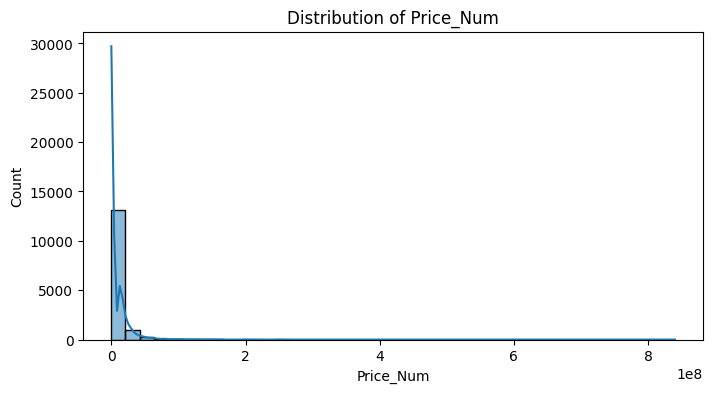

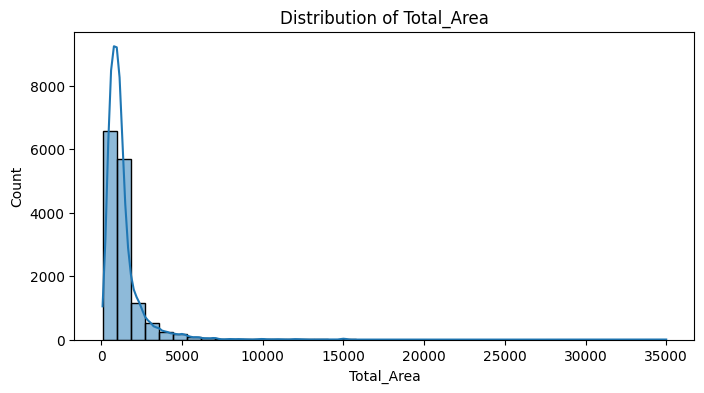

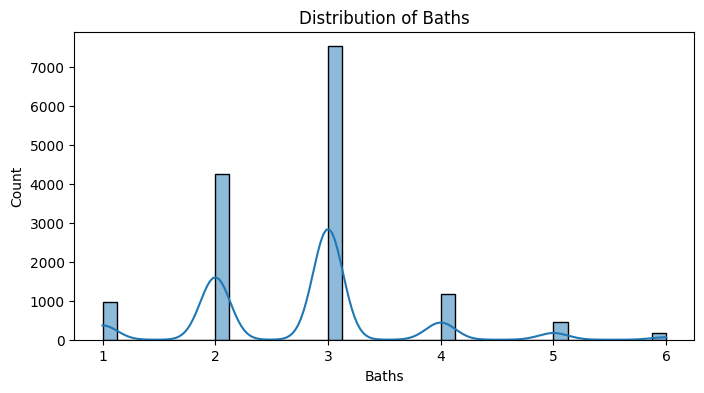

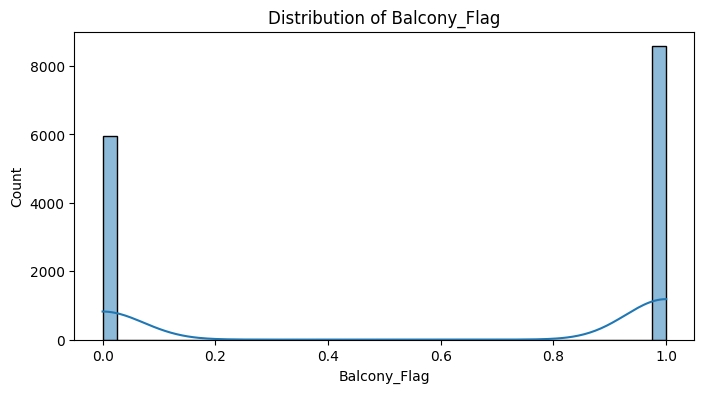

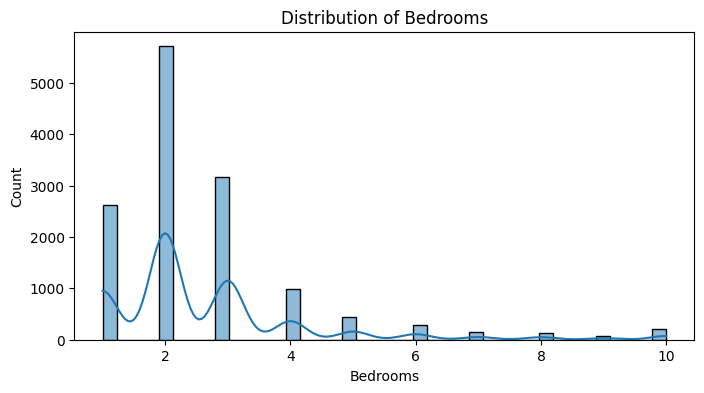

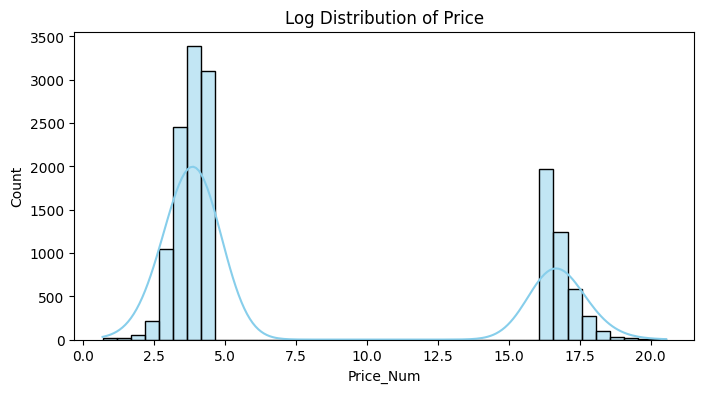

In [21]:
num_cols = ["Price_Num", "Total_Area", "Baths", "Balcony_Flag", "Bedrooms"]

for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col].dropna(), bins=40, kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

# Log transformation for skewed features
plt.figure(figsize=(8,4))
sns.histplot(np.log1p(df["Price_Num"].dropna()), bins=40, kde=True, color="skyblue")
plt.title("Log Distribution of Price")
plt.show()


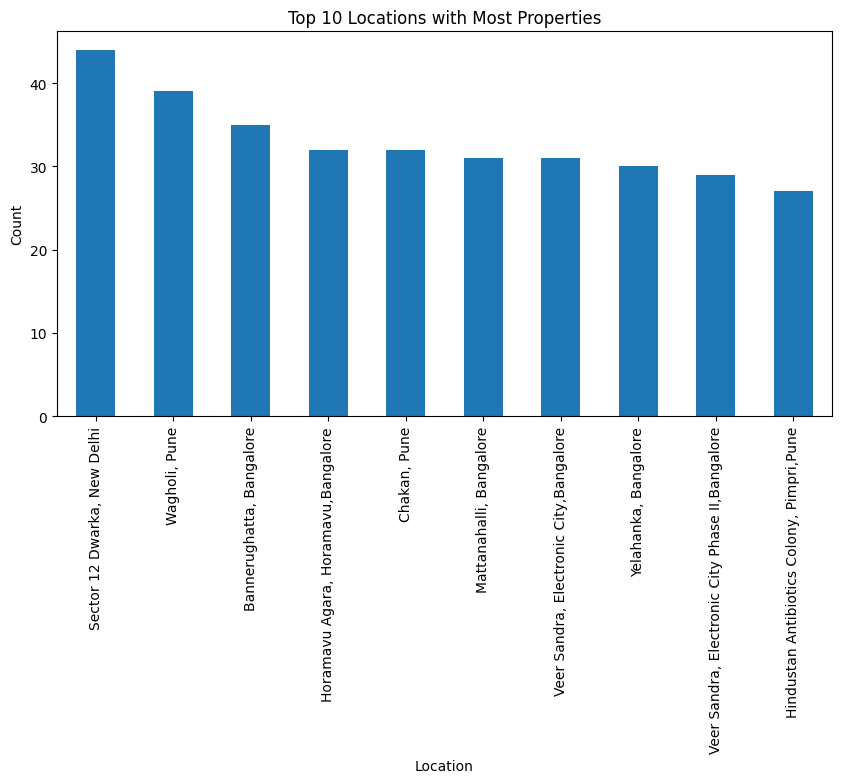

In [22]:
# Top 10 locations
plt.figure(figsize=(10,5))
df["Location"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 Locations with Most Properties")
plt.xlabel("Location")
plt.ylabel("Count")
plt.show()

Outlier Detection

Price_Num: 898 outliers detected


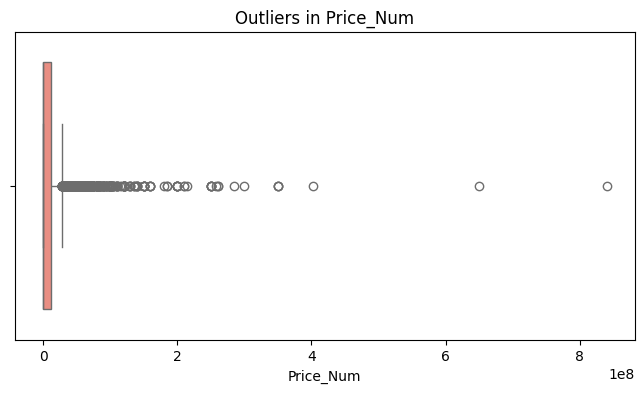

Total_Area: 1162 outliers detected


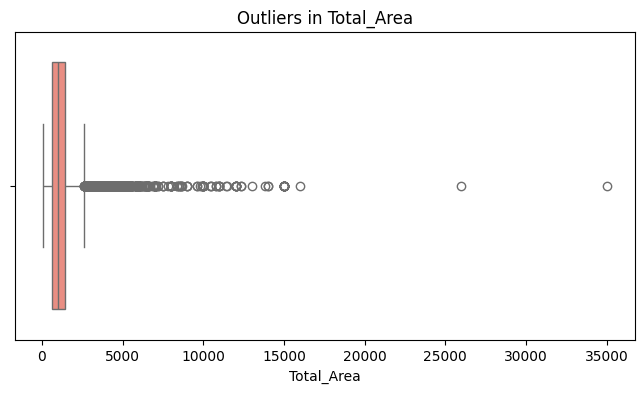

In [23]:
def detect_outliers(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[column] < (Q1 - 1.5*IQR)) | (df[column] > (Q3 + 1.5*IQR))]
    print(f"{column}: {outliers.shape[0]} outliers detected")

for col in ["Price_Num", "Total_Area"]:
    detect_outliers(col)
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col], color="salmon")
    plt.title(f"Outliers in {col}")
    plt.show()

Corelation

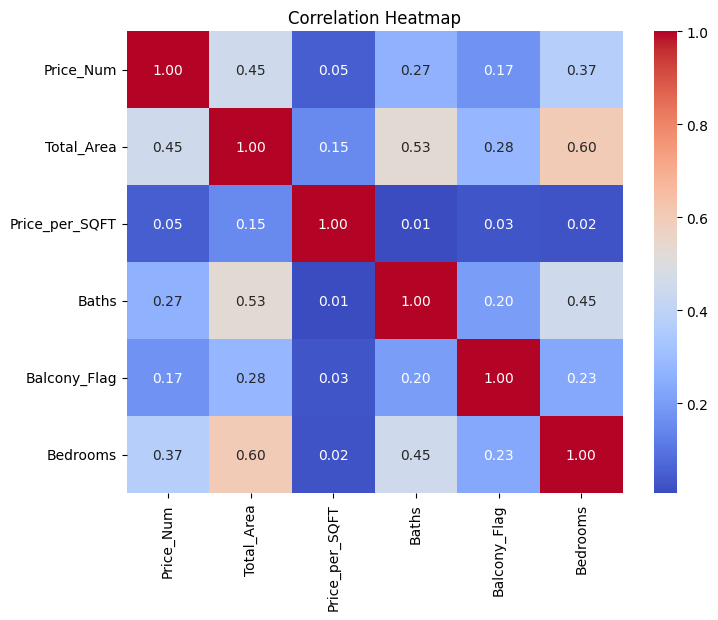

In [24]:
plt.figure(figsize=(8,6))
sns.heatmap(df[["Price_Num","Total_Area","Price_per_SQFT","Baths","Balcony_Flag","Bedrooms"]].corr(),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()